In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sklearn
print(sklearn.__version__) 

1.0.2


In [3]:
# Load data with correct test set
titanic_data = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print("Data Overview:")
display(titanic_data.head())
print("\nSummary Statistics:")
display(titanic_data.describe())

Data Overview:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Summary Statistics:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


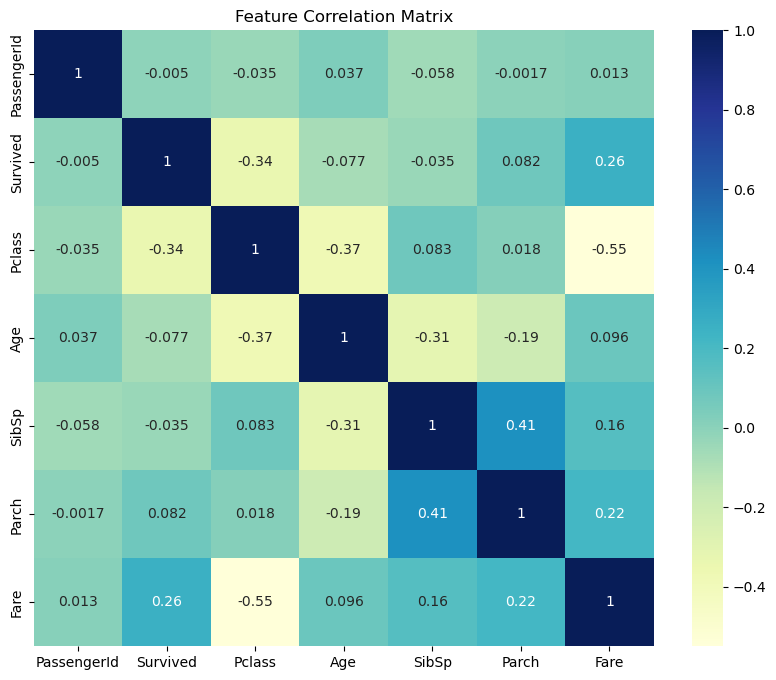

In [5]:
import seaborn as sns

numeric_data = titanic_data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), cmap="YlGnBu", annot=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,  random_state=42)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived","Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

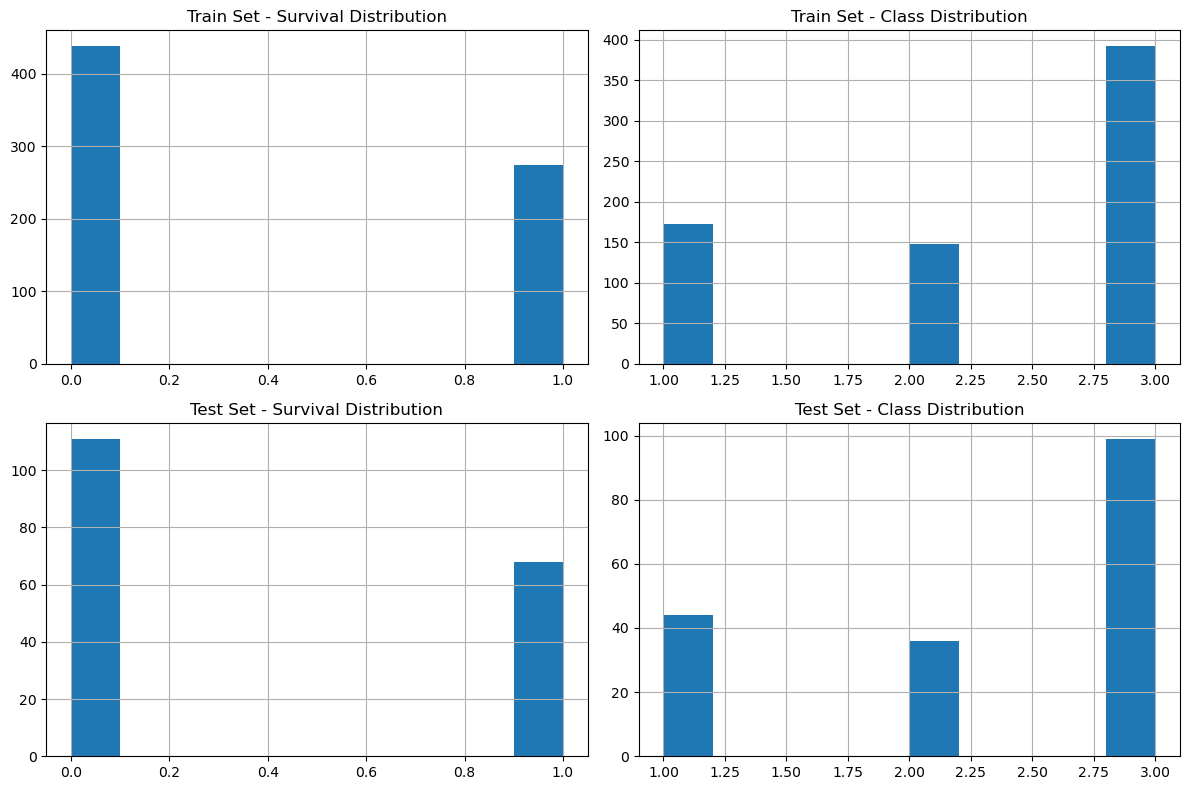

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

strat_train_set['Survived'].hist(ax=ax[0, 0])
ax[0, 0].set_title('Train Set - Survival Distribution')

strat_train_set['Pclass'].hist(ax=ax[0, 1])
ax[0, 1].set_title('Train Set - Class Distribution')

strat_test_set['Survived'].hist(ax=ax[1, 0])
ax[1, 0].set_title('Test Set - Survival Distribution')

strat_test_set['Pclass'].hist(ax=ax[1, 1])
ax[1, 1].set_title('Test Set - Class Distribution')

plt.tight_layout()
plt.show()

In [8]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [10]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X
        

In [11]:
class FeatureDropper(BaseEstimator, TransformerMixin):    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Name", "Ticket", "Cabin", "Embarked", "Sex", "N"], axis=1, errors="ignore")


In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("ageimputer", AgeImputer()),          # AgeImputer instance
    ("featureencoder", FeatureEncoder()),  # FeatureEncoder instance (fixed syntax)
    ("featuredropper", FeatureDropper())])   # FeatureDropper instance

In [13]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [14]:
strat_train_set 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
867,868,0,1,31.0,0,0,50.4958,0.0,0.0,1.0,0.0,1.0
619,620,0,2,26.0,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
50,51,0,3,7.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
286,287,1,3,30.0,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
834,835,0,3,18.0,0,0,8.3000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,0,3,50.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
518,519,1,2,36.0,1,0,26.0000,0.0,0.0,1.0,1.0,0.0
54,55,0,1,65.0,0,1,61.9792,1.0,0.0,0.0,0.0,1.0
603,604,0,3,44.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [15]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [16]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy( )

In [17]:
X_data

array([[ 1.6422641 , -1.56828591,  0.09549538, ...,  0.61197825,
        -0.73561236,  0.73561236],
       [ 0.67661178, -0.37019624, -0.29160547, ...,  0.61197825,
        -0.73561236,  0.73561236],
       [-1.53893728,  0.82789342, -1.7625887 , ...,  0.61197825,
        -0.73561236,  0.73561236],
       ...,
       [-1.52336225, -1.56828591,  2.72778116, ..., -1.63404501,
        -0.73561236,  0.73561236],
       [ 0.61431163,  0.82789342,  1.10195759, ...,  0.61197825,
        -0.73561236,  0.73561236],
       [ 1.38916974, -1.56828591, -1.45290802, ...,  0.61197825,
        -0.73561236,  0.73561236]])

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators" : [10, 100, 200, 500], "max_depth": [None, 5 ,10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(clf,param_grid, cv = 3, scoring = "accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [19]:
final_clf = grid_search.best_estimator_

In [20]:
final_clf

RandomForestClassifier(min_samples_split=4)

In [21]:
strat_test_set =  pipeline.fit_transform(strat_test_set)

In [23]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()


In [24]:
final_clf.score(X_data_test,y_data_test)

0.8268156424581006

In [25]:
final_data = pipeline.fit_transform(titanic_data)

In [26]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [29]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [30]:
production_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators" : [10, 100, 200, 500], "max_depth": [None, 5 ,10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(production_clf,param_grid, cv = 3, scoring = "accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [31]:
production_final_clf = grid_search.best_estimator_

In [33]:
production_final_clf

RandomForestClassifier(max_depth=5, n_estimators=200)

In [34]:
titanic_test_data =  test_df

In [35]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [36]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [37]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [39]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method = "ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [40]:
predictions = production_final_clf.predict(X_data_final_test)

In [43]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions.csv", index = False)

In [44]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
